<a href="https://colab.research.google.com/github/ranatoheed1/Backtesting-Automated-chart_pattern-/blob/main/pattern_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import plotly.graph_objects as go

# Load historical data
file_path = "/content/drive/MyDrive/datasets/2024-01-1h.xlsx"  # Update with actual file path
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# Parameters for backtesting
initial_balance = 10000  # Starting capital
balance = initial_balance  # Current balance
position = 0  # Current position (0 = no position, >0 = holding asset)
entry_price = 0  # Price at which the asset was bought
trade_log = []  # Log of all trades
capital_curve = []  # Tracks the balance over time
timestamps = []  # Tracks timestamps for the capital curve
win_count = 0  # Count of winning trades
lose_count = 0  # Count of losing trades

def is_bullish_engulfing(data, i):
    """
    Detects a bullish engulfing pattern.

    :param data: DataFrame containing OHLC data
    :param i: Current index in the DataFrame
    :return: True if a bullish engulfing pattern is detected, False otherwise
    """
    if i < 1:
        return False
    prev_candle, current_candle = data.iloc[i - 1], data.iloc[i]
    return (
        prev_candle['Close'] < prev_candle['Open'] and  # Previous candle is bearish
        current_candle['Close'] > current_candle['Open'] and  # Current candle is bullish
        current_candle['Close'] > prev_candle['Open'] and  # Current close > previous open
        current_candle['Open'] < prev_candle['Close']  # Current open < previous close
    )

# Backtesting loop
for i in range(1, len(df)):
    row = df.iloc[i]

    # Update capital curve (current balance + value of open position)
    capital_curve.append(balance + (position * row['Close']) if position > 0 else balance)
    timestamps.append(row['Timestamp'])

    # BUY Condition: Only buy when a bullish engulfing pattern is detected
    if position == 0 and is_bullish_engulfing(df, i):
        position = balance / row['Close']  # Buy with entire balance
        entry_price = row['Close']  # Record entry price
        balance = 0  # All balance is now in the position
        trade_log.append({
            "action": "BUY",
            "price": row['Close'],
            "timestamp": row['Timestamp']
        })

    # SELL Condition: Profit target (5%) or stop loss (3%)
    elif position > 0:
        profit_target = entry_price * 1.05  # 5% profit target
        stop_loss = entry_price * 0.97  # 3% stop loss

        if row['Close'] >= profit_target or row['Close'] <= stop_loss:
            balance = position * row['Close']  # Sell the position
            profit_loss = (row['Close'] - entry_price) * position  # Calculate profit/loss
            position = 0  # Reset position

            # Update win/lose count
            if profit_loss > 0:
                win_count += 1
            else:
                lose_count += 1

            trade_log.append({
                "action": "SELL",
                "price": row['Close'],
                "timestamp": row['Timestamp'],
                "profit_loss": profit_loss
            })

# Print trade log
print("===== Trade Log =====")
for log in trade_log:
    print(f"{log['action']} at {log['price']} on {log['timestamp']} - Profit/Loss: {log.get('profit_loss', 'N/A')}")

# Final calculations
final_balance = balance + (position * df.iloc[-1]['Close']) if position > 0 else balance
total_profit_loss = final_balance - initial_balance
total_trades = win_count + lose_count
win_ratio = (win_count / total_trades) * 100 if total_trades > 0 else 0

# Print summary
print("\n===== Backtest Summary =====")
print(f"Initial Balance: {initial_balance:.2f}")
print(f"Final Balance: {final_balance:.2f}")
print(f"Total Profit/Loss: {total_profit_loss:.2f}")
print(f"Total Trades: {total_trades}")
print(f"Win Ratio: {win_ratio:.2f}%")

# Plot capital curve
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=timestamps,
    y=capital_curve,
    mode='lines',
    name='Capital Curve',
    line=dict(color='cyan')
))
fig.update_layout(
    title="Capital Curve Over Time",
    xaxis_title="Timestamp",
    yaxis_title="Balance",
    hovermode="x unified",
    template="plotly_dark"
)
fig.show()

===== Trade Log =====
BUY at 42715.54 on 2024-01-01 13:00:00+00:00 - Profit/Loss: N/A
SELL at 45056.0 on 2024-01-02 00:00:00+00:00 - Profit/Loss: 547.9176899086373
BUY at 45119.74 on 2024-01-02 21:00:00+00:00 - Profit/Loss: N/A
SELL at 43702.88 on 2024-01-03 11:00:00+00:00 - Profit/Loss: -331.22803141427585
BUY at 43149.99 on 2024-01-04 04:00:00+00:00 - Profit/Loss: N/A
SELL at 45648.0 on 2024-01-08 17:00:00+00:00 - Profit/Loss: 591.457678989393
BUY at 46615.99 on 2024-01-09 11:00:00+00:00 - Profit/Loss: N/A
SELL at 44670.53 on 2024-01-10 12:00:00+00:00 - Profit/Loss: -451.0645020985532
BUY at 46401.89 on 2024-01-10 17:00:00+00:00 - Profit/Loss: N/A
SELL at 42510.0 on 2024-01-12 22:00:00+00:00 - Profit/Loss: -868.6850280496612
BUY at 42749.99 on 2024-01-14 05:00:00+00:00 - Profit/Loss: N/A
SELL at 41022.32 on 2024-01-18 19:00:00+00:00 - Profit/Loss: -383.4578730848679
BUY at 41239.57 on 2024-01-19 17:00:00+00:00 - Profit/Loss: N/A
SELL at 39820.31 on 2024-01-22 19:00:00+00:00 - Profit/

In [81]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load the historical data
file_path = "/content/drive/MyDrive/datasets/2024-02-1h.xlsx"  # Update with actual path
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()  # Clean column names
#df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')  # Convert timestamp to datetime

# Ensure 'Timestamp' is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Parameters for backtesting
initial_balance = 10000
balance = initial_balance
position = 0
entry_price = 0
trade_log = []
capital_curve = []
timestamps = []
win_count = 0
lose_count = 0

# Lists for visualization
buy_signals = []
sell_signals = []
bullish_flag_points = []

# Function to detect Bullish Flag pattern with multiple variations of lengths
import numpy as np

def is_bullish_flag_pattern(data, i, flagpole_lengths=[6, 8, 10], flag_lengths=[4, 5, 6, 8], flag_drop_percentage=0.01, min_angle=45, max_angle=100):
    if i < max(flagpole_lengths) + max(flag_lengths):
        return False, None  # Not enough data for the longest flagpole and flag

    # Loop through different flagpole lengths and flag lengths
    for flagpole_length in flagpole_lengths:
        for flag_length in flag_lengths:
            # Flagpole: sharp upward movement
            flagpole = data.iloc[i-flagpole_length:i]
            if flagpole['Close'].iloc[-1] <= flagpole['Close'].iloc[0]:
                continue  # No upward trend in flagpole, try the next variation

            # Calculate the angle of the flagpole
            price_difference = flagpole['Close'].iloc[-1] - flagpole['Close'].iloc[0]  # Rise
            time_periods = flagpole_length  # Run
            angle_rad = np.arctan(price_difference / time_periods)  # Calculate angle in radians
            angle_deg = np.degrees(angle_rad)  # Convert to degrees

            # Check if angle is between min_angle and max_angle
            if not (min_angle <= angle_deg <= max_angle):
                continue  # Skip if angle is out of the desired range

            # Flag: downward retracement
            flag = data.iloc[i-flagpole_length-flag_length:i-flagpole_length]
            if flag['Close'].iloc[-1] < flag['Close'].iloc[0] * (1 - flag_drop_percentage):
                flagpole_peak = flagpole['Close'].max()  # Identify the peak of the flagpole
                return True, flagpole_peak  # Flag pattern is found, return flagpole peak

    return False, None


# Backtesting loop
for i in range(1, len(df)):
    row = df.iloc[i]
    capital_curve.append(balance + (position * row['Close']) if position > 0 else balance)
    timestamps.append(row['Timestamp'])

    # Check for bullish flag pattern and breakout
    if position == 0:
        is_flag, flagpole_peak = is_bullish_flag_pattern(df, i)
        if is_flag and row['Close'] > flagpole_peak:  # Check for breakout above the flagpole's peak
            position = balance / row['Close']
            entry_price = row['Close']
            balance = 0
            trade_log.append({"action": "BUY", "price": row['Close'], "timestamp": row['Timestamp']})
            buy_signals.append((row['Timestamp'], row['Close']))
            bullish_flag_points.append((row['Timestamp'], row['Close']))  # Store bullish flag pattern detection

    # If already in position, check for exit
    elif position > 0:
        profit_threshold = entry_price * 1.05
        stop_loss = entry_price * 0.97

        if row['Close'] >= profit_threshold or row['Close'] <= stop_loss:
            balance = position * row['Close']
            profit_loss = (row['Close'] - entry_price) * position
            position = 0
            trade_log.append({"action": "SELL", "price": row['Close'], "timestamp": row['Timestamp'],
                              "profit_loss": profit_loss})
            sell_signals.append((row['Timestamp'], row['Close']))

            if profit_loss > 0:
                win_count += 1
            else:
                lose_count += 1

# Final results
for log in trade_log:
    print(f"{log['action']} at {log['price']} on {log['timestamp']} - Profit/Loss: {log.get('profit_loss', 'N/A')}")

final_balance = balance + (position * df.iloc[-1]['Close']) if position > 0 else balance
total_profit_loss = final_balance - initial_balance
win_ratio = (win_count / (win_count + lose_count) * 100) if (win_count + lose_count) > 0 else 0

print(f"Final Balance: {final_balance}")
print(f"Total Profit/Loss: {total_profit_loss}")
print(f"Win Ratio: {win_ratio:.2f}%")

# Visualization
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(
    x=df['Timestamp'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name="Candlestick"
))

# Mark BUY signals
for buy_time, buy_price in buy_signals:
    fig.add_trace(go.Scatter(
        x=[buy_time],
        y=[buy_price],
        mode="markers",
        marker=dict(color="green", size=10, symbol="triangle-up"),
        name="BUY"
    ))

# Mark SELL signals
for sell_time, sell_price in sell_signals:
    fig.add_trace(go.Scatter(
        x=[sell_time],
        y=[sell_price],
        mode="markers",
        marker=dict(color="red", size=10, symbol="triangle-down"),
        name="SELL"
    ))

# Mark Bullish Flag Pattern
for flag_time, flag_price in bullish_flag_points:
    fig.add_trace(go.Scatter(
        x=[flag_time],
        y=[flag_price],
        mode="markers",
        marker=dict(color="blue", size=8, symbol="circle"),
        name="Bullish Flag"
    ))

# Layout settings
fig.update_layout(
    title="Price Chart with Buy/Sell Signals & Bullish Flag Pattern",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False,
    template="plotly_dark"
)

# Show the plot
fig.show()


BUY at 43071.88 on 2024-02-05 07:00:00+00:00 - Profit/Loss: N/A
SELL at 45432.3 on 2024-02-08 15:00:00+00:00 - Profit/Loss: 548.0188002009677
BUY at 47531.09 on 2024-02-10 19:00:00+00:00 - Profit/Loss: N/A
SELL at 49917.8 on 2024-02-12 15:00:00+00:00 - Profit/Loss: 529.6546313292567
BUY at 49399.41 on 2024-02-13 20:00:00+00:00 - Profit/Loss: N/A
SELL at 51908.45 on 2024-02-14 14:00:00+00:00 - Profit/Loss: 562.6448928569495
BUY at 52621.31 on 2024-02-15 14:00:00+00:00 - Profit/Loss: N/A
SELL at 50841.09 on 2024-02-17 14:00:00+00:00 - Profit/Loss: -393.8010567855598
BUY at 51514.0 on 2024-02-17 20:00:00+00:00 - Profit/Loss: N/A
SELL at 54487.11 on 2024-02-26 19:00:00+00:00 - Profit/Loss: 649.0882663640764
BUY at 62443.9 on 2024-02-29 04:00:00+00:00 - Profit/Loss: N/A
Final Balance: 11645.493378612577
Total Profit/Loss: 1645.4933786125766
Win Ratio: 80.00%


In [85]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


In [91]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load the historical data
file_path = "/content/drive/MyDrive/datasets/2024-02-1h.xlsx"  # Update with actual path
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()  # Clean column names

# Ensure 'Timestamp' is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Parameters for backtesting
initial_balance = 10000
balance = initial_balance
position = 0
entry_price = 0
trade_log = []
capital_curve = []
timestamps = []
win_count = 0
lose_count = 0

# Lists for visualization
buy_signals = []
sell_signals = []
bullish_flag_points = []
flagpole_lines = []

# Function to detect Bullish Flag pattern with multiple variations of lengths
import numpy as np

def is_bullish_flag_pattern(data, i, flagpole_lengths=[6, 8, 10], flag_lengths=[4, 5, 6, 8], flag_drop_percentage=0.01, min_angle=45, max_angle=100):
    if i < max(flagpole_lengths) + max(flag_lengths):
        return False, None, None  # Not enough data for the longest flagpole and flag

    # Loop through different flagpole lengths and flag lengths
    for flagpole_length in flagpole_lengths:
        for flag_length in flag_lengths:
            # Flagpole: sharp upward movement
            flagpole = data.iloc[i-flagpole_length:i]
            if flagpole['Close'].iloc[-1] <= flagpole['Close'].iloc[0]:
                continue  # No upward trend in flagpole, try the next variation

            # Calculate the angle of the flagpole
            price_difference = flagpole['Close'].iloc[-1] - flagpole['Close'].iloc[0]  # Rise
            time_periods = flagpole_length  # Run
            angle_rad = np.arctan(price_difference / time_periods)  # Calculate angle in radians
            angle_deg = np.degrees(angle_rad)  # Convert to degrees

            # Check if angle is between min_angle and max_angle
            if not (min_angle <= angle_deg <= max_angle):
                continue  # Skip if angle is out of the desired range

            # Flag: downward retracement
            flag = data.iloc[i-flagpole_length-flag_length:i-flagpole_length]
            if flag['Close'].iloc[-1] < flag['Close'].iloc[0] * (1 - flag_drop_percentage):
                flagpole_peak = flagpole['Close'].max()  # Identify the peak of the flagpole
                flagpole_start = flagpole['Close'].iloc[0]
                return True, flagpole_start, flagpole_peak  # Flag pattern is found, return flagpole start & peak

    return False, None, None

# Backtesting loop
for i in range(1, len(df)):
    row = df.iloc[i]
    capital_curve.append(balance + (position * row['Close']) if position > 0 else balance)
    timestamps.append(row['Timestamp'])

    # Check for bullish flag pattern and breakout
    if position == 0:
        is_flag, flagpole_start, flagpole_peak = is_bullish_flag_pattern(df, i)
        if is_flag and row['Close'] > flagpole_peak:  # Check for breakout above the flagpole's peak
            position = balance / row['Close']
            entry_price = row['Close']
            balance = 0
            trade_log.append({"action": "BUY", "price": row['Close'], "timestamp": row['Timestamp']})
            buy_signals.append((row['Timestamp'], row['Close']))
            bullish_flag_points.append((row['Timestamp'], row['Close']))  # Store bullish flag pattern detection
            flagpole_lines.append((df.iloc[i-10]['Timestamp'], flagpole_start, row['Timestamp'], flagpole_peak))  # Store flagpole line

    # If already in position, check for exit
    elif position > 0:
        profit_threshold = entry_price * 1.05
        stop_loss = entry_price * 0.97

        if row['Close'] >= profit_threshold or row['Close'] <= stop_loss:
            balance = position * row['Close']
            profit_loss = (row['Close'] - entry_price) * position
            position = 0
            trade_log.append({"action": "SELL", "price": row['Close'], "timestamp": row['Timestamp'],
                              "profit_loss": profit_loss})
            sell_signals.append((row['Timestamp'], row['Close']))

            if profit_loss > 0:
                win_count += 1
            else:
                lose_count += 1

# Final results
for log in trade_log:
    print(f"{log['action']} at {log['price']} on {log['timestamp']} - Profit/Loss: {log.get('profit_loss', 'N/A')}")

final_balance = balance + (position * df.iloc[-1]['Close']) if position > 0 else balance
total_profit_loss = final_balance - initial_balance
win_ratio = (win_count / (win_count + lose_count) * 100) if (win_count + lose_count) > 0 else 0

print(f"Final Balance: {final_balance}")
print(f"Total Profit/Loss: {total_profit_loss}")
print(f"Win Ratio: {win_ratio:.2f}%")

# Visualization
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(
    x=df['Timestamp'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name="Candlestick"
))

# Mark BUY signals
for buy_time, buy_price in buy_signals:
    fig.add_trace(go.Scatter(
        x=[buy_time],
        y=[buy_price],
        mode="markers",
        marker=dict(color="green", size=10, symbol="triangle-up"),
        name="BUY"
    ))

# Mark SELL signals
for sell_time, sell_price in sell_signals:
    fig.add_trace(go.Scatter(
        x=[sell_time],
        y=[sell_price],
        mode="markers",
        marker=dict(color="yellow", size=10, symbol="triangle-down"),
        name="SELL"
    ))

# Mark Bullish Flag Pattern
for flag_time, flag_price in bullish_flag_points:
    fig.add_trace(go.Scatter(
        x=[flag_time],
        y=[flag_price],
        mode="markers",
        marker=dict(color="blue", size=8, symbol="circle"),
        name="Bullish Flag"
    ))

# Draw Flagpole Lines
for start_time, start_price, end_time, end_price in flagpole_lines:
    fig.add_trace(go.Scatter(
        x=[start_time, end_time],
        y=[start_price, end_price],
        mode="lines",
        line=dict(color="white", width=2, dash="dash"),
        name="Flagpole"
    ))

# Layout settings
fig.update_layout(
    title="Price Chart with Buy/Sell Signals & Bullish Flag Pattern",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False,
    template="plotly_dark"
)

# Show the plot
fig.show()


BUY at 43071.88 on 2024-02-05 07:00:00+00:00 - Profit/Loss: N/A
SELL at 45432.3 on 2024-02-08 15:00:00+00:00 - Profit/Loss: 548.0188002009677
BUY at 47531.09 on 2024-02-10 19:00:00+00:00 - Profit/Loss: N/A
SELL at 49917.8 on 2024-02-12 15:00:00+00:00 - Profit/Loss: 529.6546313292567
BUY at 49399.41 on 2024-02-13 20:00:00+00:00 - Profit/Loss: N/A
SELL at 51908.45 on 2024-02-14 14:00:00+00:00 - Profit/Loss: 562.6448928569495
BUY at 52621.31 on 2024-02-15 14:00:00+00:00 - Profit/Loss: N/A
SELL at 50841.09 on 2024-02-17 14:00:00+00:00 - Profit/Loss: -393.8010567855598
BUY at 51514.0 on 2024-02-17 20:00:00+00:00 - Profit/Loss: N/A
SELL at 54487.11 on 2024-02-26 19:00:00+00:00 - Profit/Loss: 649.0882663640764
BUY at 62443.9 on 2024-02-29 04:00:00+00:00 - Profit/Loss: N/A
Final Balance: 11645.493378612577
Total Profit/Loss: 1645.4933786125766
Win Ratio: 80.00%


In [11]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load the historical data
file_path = "/content/drive/MyDrive/datasets/2024-02-1h.xlsx"  # Update with actual path
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()  # Clean column names

# Ensure 'Timestamp' is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Parameters for backtesting
initial_balance = 10000
balance = initial_balance
position = 0
entry_price = 0
trade_log = []
capital_curve = []
timestamps = []
win_count = 0
lose_count = 0

# Lists for visualization
buy_signals = []
sell_signals = []
bullish_flag_points = []
flagpole_lines = []

# Function to detect Bullish Flag pattern with multiple variations of lengths
import numpy as np

def is_bullish_flag_pattern(data, i, flagpole_lengths=[6, 8, 10], flag_lengths=[4, 5, 6, 8], flag_drop_percentage=0.01, min_angle=45, max_angle=90):
    if i < max(flagpole_lengths) + max(flag_lengths):
        return False, None, None  # Not enough data for the longest flagpole and flag

    # Loop through different flagpole lengths and flag lengths
    for flagpole_length in flagpole_lengths:
        for flag_length in flag_lengths:
            # Flagpole: sharp upward movement
            flagpole = data.iloc[i-flagpole_length:i]
            if flagpole['Close'].iloc[-1] <= flagpole['Close'].iloc[0]:
                continue  # No upward trend in flagpole, try the next variation

            # Calculate the angle of the flagpole
            price_difference = flagpole['Close'].iloc[-1] - flagpole['Close'].iloc[0]  # Rise
            time_periods = flagpole_length  # Run
            angle_rad = np.arctan(price_difference / time_periods)  # Calculate angle in radians
            angle_deg = np.degrees(angle_rad)  # Convert to degrees

            # Check if angle is between min_angle and max_angle (45 to 90 degrees)
            if not (min_angle <= angle_deg <= max_angle):
                continue  # Skip if angle is out of the desired range

            # Flag: downward retracement
            flag = data.iloc[i-flagpole_length-flag_length:i-flagpole_length]
            if flag['Close'].iloc[-1] < flag['Close'].iloc[0] * (1 - flag_drop_percentage):
                flagpole_peak = flagpole['Close'].max()  # Identify the peak of the flagpole
                flagpole_start = flagpole['Close'].iloc[0]
                return True, flagpole_start, flagpole_peak  # Flag pattern is found, return flagpole start & peak

    return False, None, None


# Backtesting loop
for i in range(1, len(df)):
    row = df.iloc[i]
    capital_curve.append(balance + (position * row['Close']) if position > 0 else balance)
    timestamps.append(row['Timestamp'])

    # Check for bullish flag pattern and breakout
    if position == 0:
        is_flag, flagpole_start, flagpole_peak = is_bullish_flag_pattern(df, i)

        # Debug: print flag detection and breakout condition
        if is_flag:
            print(f"Bullish Flag Detected at {df.iloc[i]['Timestamp']} with flagpole peak at {flagpole_peak}")

        if is_flag:
            print(f"Flagpole Peak: {flagpole_peak}, Current Close: {row['Close']}")
            if row['Close'] > flagpole_peak:  # Check for breakout above the flagpole's peak
                print(f"BUY Signal at {row['Timestamp']} - {row['Close']}")
                position = balance / row['Close']
                entry_price = row['Close']
                balance = 0
                trade_log.append({"action": "BUY", "price": row['Close'], "timestamp": row['Timestamp']})
                buy_signals.append((row['Timestamp'], row['Close']))
                bullish_flag_points.append((row['Timestamp'], row['Close']))  # Store bullish flag pattern detection
                flagpole_lines.append((df.iloc[i-10]['Timestamp'], flagpole_start, row['Timestamp'], flagpole_peak))  # Store flagpole line

    # If already in position, check for exit
    elif position > 0:
        profit_threshold = entry_price * 1.05
        stop_loss = entry_price * 0.97

        if row['Close'] >= profit_threshold or row['Close'] <= stop_loss:
            balance = position * row['Close']
            profit_loss = (row['Close'] - entry_price) * position
            position = 0
            trade_log.append({"action": "SELL", "price": row['Close'], "timestamp": row['Timestamp'],
                              "profit_loss": profit_loss})
            sell_signals.append((row['Timestamp'], row['Close']))

            if profit_loss > 0:
                win_count += 1
            else:
                lose_count += 1

# Final results
for log in trade_log:
    print(f"{log['action']} at {log['price']} on {log['timestamp']} - Profit/Loss: {log.get('profit_loss', 'N/A')}")

final_balance = balance + (position * df.iloc[-1]['Close']) if position > 0 else balance
total_profit_loss = final_balance - initial_balance
win_ratio = (win_count / (win_count + lose_count) * 100) if (win_count + lose_count) > 0 else 0

print(f"Final Balance: {final_balance}")
print(f"Total Profit/Loss: {total_profit_loss}")
print(f"Win Ratio: {win_ratio:.2f}%")

# Visualization
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(
    x=df['Timestamp'],
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name="Candlestick"
))

# Mark BUY signals
for buy_time, buy_price in buy_signals:
    fig.add_trace(go.Scatter(
        x=[buy_time],
        y=[buy_price],
        mode="markers",
        marker=dict(color="green", size=10, symbol="triangle-up"),
        name="BUY"
    ))

# Mark SELL signals
for sell_time, sell_price in sell_signals:
    fig.add_trace(go.Scatter(
        x=[sell_time],
        y=[sell_price],
        mode="markers",
        marker=dict(color="yellow", size=10, symbol="triangle-down"),
        name="SELL"
    ))

# Mark Bullish Flag Pattern
for flag_time, flag_price in bullish_flag_points:
    fig.add_trace(go.Scatter(
        x=[flag_time],
        y=[flag_price],
        mode="markers",
        marker=dict(color="blue", size=8, symbol="circle"),
        name="Bullish Flag"
    ))

# Draw Flagpole Lines
for start_time, start_price, end_time, end_price in flagpole_lines:
    fig.add_trace(go.Scatter(
        x=[start_time, end_time],
        y=[start_price, end_price],
        mode="lines",
        line=dict(color="white", width=2, dash="dash"),
        name="Flagpole"
    ))

# Layout settings
fig.update_layout(
    title="Price Chart with Buy/Sell Signals & Bullish Flag Pattern",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False,
    template="plotly_dark"
)

# Show the plot
fig.show()


Bullish Flag Detected at 2024-02-02 20:00:00+00:00 with flagpole peak at 43242.09
Flagpole Peak: 43242.09, Current Close: 42952.65
Bullish Flag Detected at 2024-02-02 22:00:00+00:00 with flagpole peak at 43242.09
Flagpole Peak: 43242.09, Current Close: 43202.59
Bullish Flag Detected at 2024-02-03 00:00:00+00:00 with flagpole peak at 43242.09
Flagpole Peak: 43242.09, Current Close: 43229.07
Bullish Flag Detected at 2024-02-05 07:00:00+00:00 with flagpole peak at 42819.32
Flagpole Peak: 42819.32, Current Close: 43071.88
BUY Signal at 2024-02-05 07:00:00+00:00 - 43071.88
Bullish Flag Detected at 2024-02-10 07:00:00+00:00 with flagpole peak at 47409.5
Flagpole Peak: 47409.5, Current Close: 47151.72
Bullish Flag Detected at 2024-02-10 17:00:00+00:00 with flagpole peak at 47353.48
Flagpole Peak: 47353.48, Current Close: 47196.48
Bullish Flag Detected at 2024-02-10 19:00:00+00:00 with flagpole peak at 47353.48
Flagpole Peak: 47353.48, Current Close: 47531.09
BUY Signal at 2024-02-10 19:00:00+

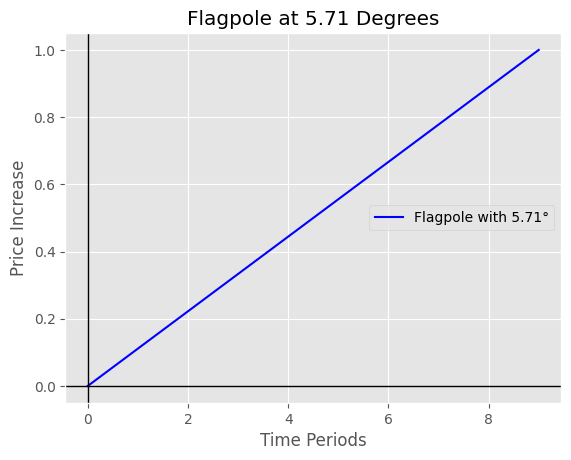

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data for a flagpole with a 45-degree angle
# Let's assume the flagpole rises over 10 periods with a price increase of 1 unit per period
time_periods = 10
price_increase = 1  # Let's make the price increase 1 unit per period
price_difference = price_increase  # Rise

# Calculate the angle in radians
angle_rad = np.arctan(price_difference / time_periods)  # Calculate angle in radians
angle_deg = np.degrees(angle_rad)  # Convert to degrees

# Generate the flagpole data points
flagpole_x = np.arange(time_periods)
flagpole_y = np.linspace(0, price_increase, time_periods)

# Plotting the flagpole
plt.plot(flagpole_x, flagpole_y, label=f"Flagpole with {angle_deg:.2f}°", color="blue")
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)

# Add labels and title
plt.title(f"Flagpole at {angle_deg:.2f} Degrees")
plt.xlabel("Time Periods")
plt.ylabel("Price Increase")
plt.legend()

# Display the plot
plt.show()


In [16]:
#DOUBLE BOTTOM PATTERN
import pandas as pd
import plotly.graph_objects as go

# Load historical data
file_path = "/content/drive/MyDrive/datasets/BTCUSDT-1h-2024-12.csv"  # Update with actual file path
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
# Parameters for backtesting
initial_balance = 10000  # Starting capital
balance = initial_balance  # Current balance
position = 0  # Current position (0 = no position, >0 = holding asset)
entry_price = 0  # Price at which the asset was bought
trade_log = []  # Log of all trades
capital_curve = []  # Tracks the balance over time
timestamps = []  # Tracks timestamps for the capital curve
win_count = 0  # Count of winning trades
lose_count = 0  # Count of losing trades

def is_bullish_double_bottom(data, i):
    """
    Detects a bullish double bottom pattern.
    :param data: DataFrame containing OHLC data
    :param i: Current index in the DataFrame
    :return: True if a bullish double bottom pattern is detected, False otherwise
    """
    if i < 2:
        return False
    low1, low2 = data.iloc[i - 2]['Low'], data.iloc[i]['Low']
    neckline = data.iloc[i - 1]['High']
    return (
        abs(low1 - low2) / low1 < 0.01 and  # Lows are nearly equal
        data.iloc[i]['Close'] > neckline  # Breakout above neckline
    )

# Backtesting loop
for i in range(2, len(df)):
    row = df.iloc[i]

    # Update capital curve (current balance + value of open position)
    capital_curve.append(balance + (position * row['Close']) if position > 0 else balance)
    timestamps.append(row['Timestamp'])

    # BUY Condition: Only buy when a bullish double bottom pattern is detected
    if position == 0 and is_bullish_double_bottom(df, i):
        position = balance / row['Close']  # Buy with entire balance
        entry_price = row['Close']  # Record entry price
        balance = 0  # All balance is now in the position
        trade_log.append({
            "action": "BUY",
            "price": row['Close'],
            "timestamp": row['Timestamp']
        })

    # SELL Condition: Profit target (5%) or stop loss (3%)
    elif position > 0:
        profit_target = entry_price * 1.05  # 5% profit target
        stop_loss = entry_price * 0.97  # 3% stop loss

        if row['Close'] >= profit_target or row['Close'] <= stop_loss:
            balance = position * row['Close']  # Sell the position
            profit_loss = (row['Close'] - entry_price) * position  # Calculate profit/loss
            position = 0  # Reset position

            # Update win/lose count
            if profit_loss > 0:
                win_count += 1
            else:
                lose_count += 1

            trade_log.append({
                "action": "SELL",
                "price": row['Close'],
                "timestamp": row['Timestamp'],
                "profit_loss": profit_loss
            })

# Print trade log
print("===== Trade Log =====")
for log in trade_log:
    print(f"{log['action']} at {log['price']} on {log['timestamp']} - Profit/Loss: {log.get('profit_loss', 'N/A')}")

# Final calculations
final_balance = balance + (position * df.iloc[-1]['Close']) if position > 0 else balance
total_profit_loss = final_balance - initial_balance
total_trades = win_count + lose_count
win_ratio = (win_count / total_trades) * 100 if total_trades > 0 else 0

# Print summary
print("\n===== Backtest Summary =====")
print(f"Initial Balance: {initial_balance:.2f}")
print(f"Final Balance: {final_balance:.2f}")
print(f"Total Profit/Loss: {total_profit_loss:.2f}")
print(f"Total Trades: {total_trades}")
print(f"Win Ratio: {win_ratio:.2f}%")

# Plot capital curve
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=timestamps,
    y=capital_curve,
    mode='lines',
    name='Capital Curve',
    line=dict(color='cyan')
))
fig.update_layout(
    title="Capital Curve Over Time",
    xaxis_title="Timestamp",
    yaxis_title="Balance",
    hovermode="x unified",
    template="plotly_dark"
)
fig.show()

===== Trade Log =====
BUY at 96515.52 on 2024-12-01 05:13:20 - Profit/Loss: N/A
SELL at 102964.0 on 2024-12-05 03:40:00 - Profit/Loss: 668.1288149304895
BUY at 102764.0 on 2024-12-05 09:13:20 - Profit/Loss: N/A
SELL at 99028.0 on 2024-12-05 20:20:00 - Profit/Loss: -387.8413574070716
BUY at 97877.5 on 2024-12-06 04:40:00 - Profit/Loss: N/A
SELL at 94484.01 on 2024-12-10 17:00:00 - Profit/Loss: -356.4256615078153
BUY at 95856.5 on 2024-12-10 19:46:40 - Profit/Loss: N/A
SELL at 101122.71 on 2024-12-11 18:00:00 - Profit/Loss: 545.2018405511925
BUY at 101824.76 on 2024-12-12 02:20:00 - Profit/Loss: N/A
SELL at 107078.55 on 2024-12-16 17:26:40 - Profit/Loss: 540.165887384938
BUY at 106376.0 on 2024-12-17 01:46:40 - Profit/Loss: N/A
SELL at 102817.82 on 2024-12-18 19:26:40 - Profit/Loss: -368.2486680034453
BUY at 101193.15 on 2024-12-19 03:46:40 - Profit/Loss: N/A
SELL at 97199.72 on 2024-12-19 17:40:00 - Profit/Loss: -419.92973021958
BUY at 97417.66 on 2024-12-19 20:26:40 - Profit/Loss: N/A


In [4]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4127    0  4127    0     0   9662      0 --:--:-- --:--:-- --:--:--  9687
100  517k  100  517k    0     0   475k      0  0:00:01  0:00:01 --:--:--  910k
--2025-01-30 08:09:52--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.145.37, 104.19.144.37, 2606:4700::6813:9025, ...
Connecting to anaconda.org (anaconda.org)|104.19.145.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=